# Description

Plots results.

# Modules

In [1]:
import pandas as pd
import seaborn as sns
from IPython.display import display
from proj import conf

# Settings/paths

In [2]:
INPUT_DIR = conf.common.LLM_PAIRWISE_DIR
assert INPUT_DIR.exists()
display(INPUT_DIR)

PosixPath('/home/miltondp/projects/others/manubot/manubot-ai-editor-code/base/results/llm_pairwise')

In [3]:
MANUSCRIPT_OUTPUT_DIR = conf.manuscript.FIGURES_DIR
MANUSCRIPT_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
display(MANUSCRIPT_OUTPUT_DIR)

PosixPath('/home/miltondp/projects/others/manubot/manubot-gpt-manuscript/content/images')

# Load LLM pairwise files

In [4]:
result_files = list(INPUT_DIR.glob("*.pkl"))
display(len(result_files))
display(result_files[:2])

16

[PosixPath('/home/miltondp/projects/others/manubot/manubot-ai-editor-code/base/results/llm_pairwise/epistasis-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl'),
 PosixPath('/home/miltondp/projects/others/manubot/manubot-ai-editor-code/base/results/llm_pairwise/phenoplier-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl')]

In [5]:
pd.read_pickle(result_files[0])

,rep_index,paragraph_index,paragraph_section,winner,rationale,winner_score
0,0,0,abstract,Paragraph 1,Paragraph 1 slightly edges out Paragraph A in ...,1.0
1,0,1,introduction,tie,Both paragraphs exhibit clear sentence structu...,0.0
2,0,2,introduction,Paragraph 1,Paragraph 1 is slightly better due to the abse...,1.0
3,0,3,introduction,Paragraph 1,Both paragraphs exhibit clear sentence structu...,1.0
4,0,4,introduction,Paragraph 1,Both paragraphs exhibit clear sentence structu...,1.0
...,...,...,...,...,...,...
310,4,58,methods,tie,Both paragraphs exhibit clear sentence structu...,0.0
311,4,59,methods,Paragraph A,Paragraph A excels in having a clear sentence ...,-1.0
312,4,60,methods,Paragraph 1,Paragraph 1 is slightly better due to maintain...,1.0
313,4,61,methods,tie,Both paragraphs exhibit clear sentence structu...,0.0


In [6]:
result_files[0].name.split("--")

['epistasis-manuscript', 'gpt-3.5-turbo', 'openai_gpt-3.5-turbo.pkl']

In [7]:
all_results = []

for f in result_files:
    print(f.name, flush=True)
    df = pd.read_pickle(f)

    f_name_parts = f.name.split("--")
    idx = 0
    manuscript_code = f_name_parts[idx]
    manuscript_code = manuscript_code.split("-manuscript")[0]
    idx += 1

    manuscript_pr_model = f_name_parts[idx]
    idx += 1

    reversed_paragraphs = False
    if len(f_name_parts) > 3:
        reversed_paragraphs = f_name_parts[idx] == "reversed"
        idx += 1

    llm_judge = f_name_parts[idx].split(".pkl")[0]

    df.insert(0, "llm_judge", llm_judge)
    df.insert(0, "paragraphs_reversed", reversed_paragraphs)
    df.insert(0, "pr_model", manuscript_pr_model)
    df.insert(0, "manuscript_code", manuscript_code)

    all_results.append(df)

epistasis-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl
phenoplier-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl
ccc-manuscript--gpt-3.5-turbo--reversed--openai_gpt-3.5-turbo.pkl
phenoplier-manuscript--gpt-3.5-turbo--reversed--openai_gpt-4-turbo-preview.pkl
phenoplier-manuscript--gpt-3.5-turbo--reversed--openai_gpt-3.5-turbo.pkl
ccc-manuscript--gpt-3.5-turbo--reversed--openai_gpt-4-turbo-preview.pkl
epistasis-manuscript--gpt-3.5-turbo--openai_gpt-4-turbo-preview.pkl
biochatter-manuscript--gpt-3.5-turbo--openai_gpt-4-turbo-preview.pkl
epistasis-manuscript--gpt-3.5-turbo--reversed--openai_gpt-3.5-turbo.pkl
biochatter-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl
ccc-manuscript--gpt-3.5-turbo--openai_gpt-4-turbo-preview.pkl
epistasis-manuscript--gpt-3.5-turbo--reversed--openai_gpt-4-turbo-preview.pkl
ccc-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl
biochatter-manuscript--gpt-3.5-turbo--reversed--openai_gpt-3.5-turbo.pkl
biochatter-manuscript--gpt-3.5-turbo--revers

In [8]:
df = pd.concat(all_results, ignore_index=True)

In [9]:
df.shape

(3880, 10)

In [10]:
df.head()

,manuscript_code,pr_model,paragraphs_reversed,llm_judge,rep_index,paragraph_index,paragraph_section,winner,rationale,winner_score
0,epistasis,gpt-3.5-turbo,False,openai_gpt-3.5-turbo,0,0,abstract,Paragraph 1,Paragraph 1 slightly edges out Paragraph A in ...,1.0
1,epistasis,gpt-3.5-turbo,False,openai_gpt-3.5-turbo,0,1,introduction,tie,Both paragraphs exhibit clear sentence structu...,0.0
2,epistasis,gpt-3.5-turbo,False,openai_gpt-3.5-turbo,0,2,introduction,Paragraph 1,Paragraph 1 is slightly better due to the abse...,1.0
3,epistasis,gpt-3.5-turbo,False,openai_gpt-3.5-turbo,0,3,introduction,Paragraph 1,Both paragraphs exhibit clear sentence structu...,1.0
4,epistasis,gpt-3.5-turbo,False,openai_gpt-3.5-turbo,0,4,introduction,Paragraph 1,Both paragraphs exhibit clear sentence structu...,1.0


# Process data for plotting

## Reverse scores for reversed paragraphs

In [11]:
df.loc[df["paragraphs_reversed"], "winner_score"] = (
    -1 * df.loc[df["paragraphs_reversed"], "winner_score"]
)

## Rename values

In [12]:
df["llm_judge"].unique()

array(['openai_gpt-3.5-turbo', 'openai_gpt-4-turbo-preview'], dtype=object)

In [13]:
models_rename = {
    "openai_gpt-4": "GPT-4",
    "openai_gpt-4-turbo-preview": "GPT-4 Turbo",
    "openai_gpt-3.5-turbo": "GPT-3.5 Turbo",
    "mistral_7b-instruct-fp16": "Mistral 7b",
}

In [14]:
df["manuscript_code"].unique()

array(['epistasis', 'phenoplier', 'ccc', 'biochatter'], dtype=object)

In [15]:
df["paragraph_section"].unique()

array(['abstract', 'introduction', 'results', 'discussion', 'methods',
       'supplementary material'], dtype=object)

In [16]:
df = df.replace(
    {
        "manuscript_code": {
            "biochatter": "BioChatter",
            "ccc": "CCC",
            "phenoplier": "PhenoPLIER",
            "epistasis": "Epistasis",
        },
        "pr_model": models_rename,
        "llm_judge": models_rename,
        "paragraph_section": {
            "abstract": "Abstract",
            "introduction": "Introduction",
            "results": "Results",
            "methods": "Methods",
            "discussion": "Discussion",
            "supplementary material": "Suppl.\nmaterial",
        },
    }
)

# Full plot

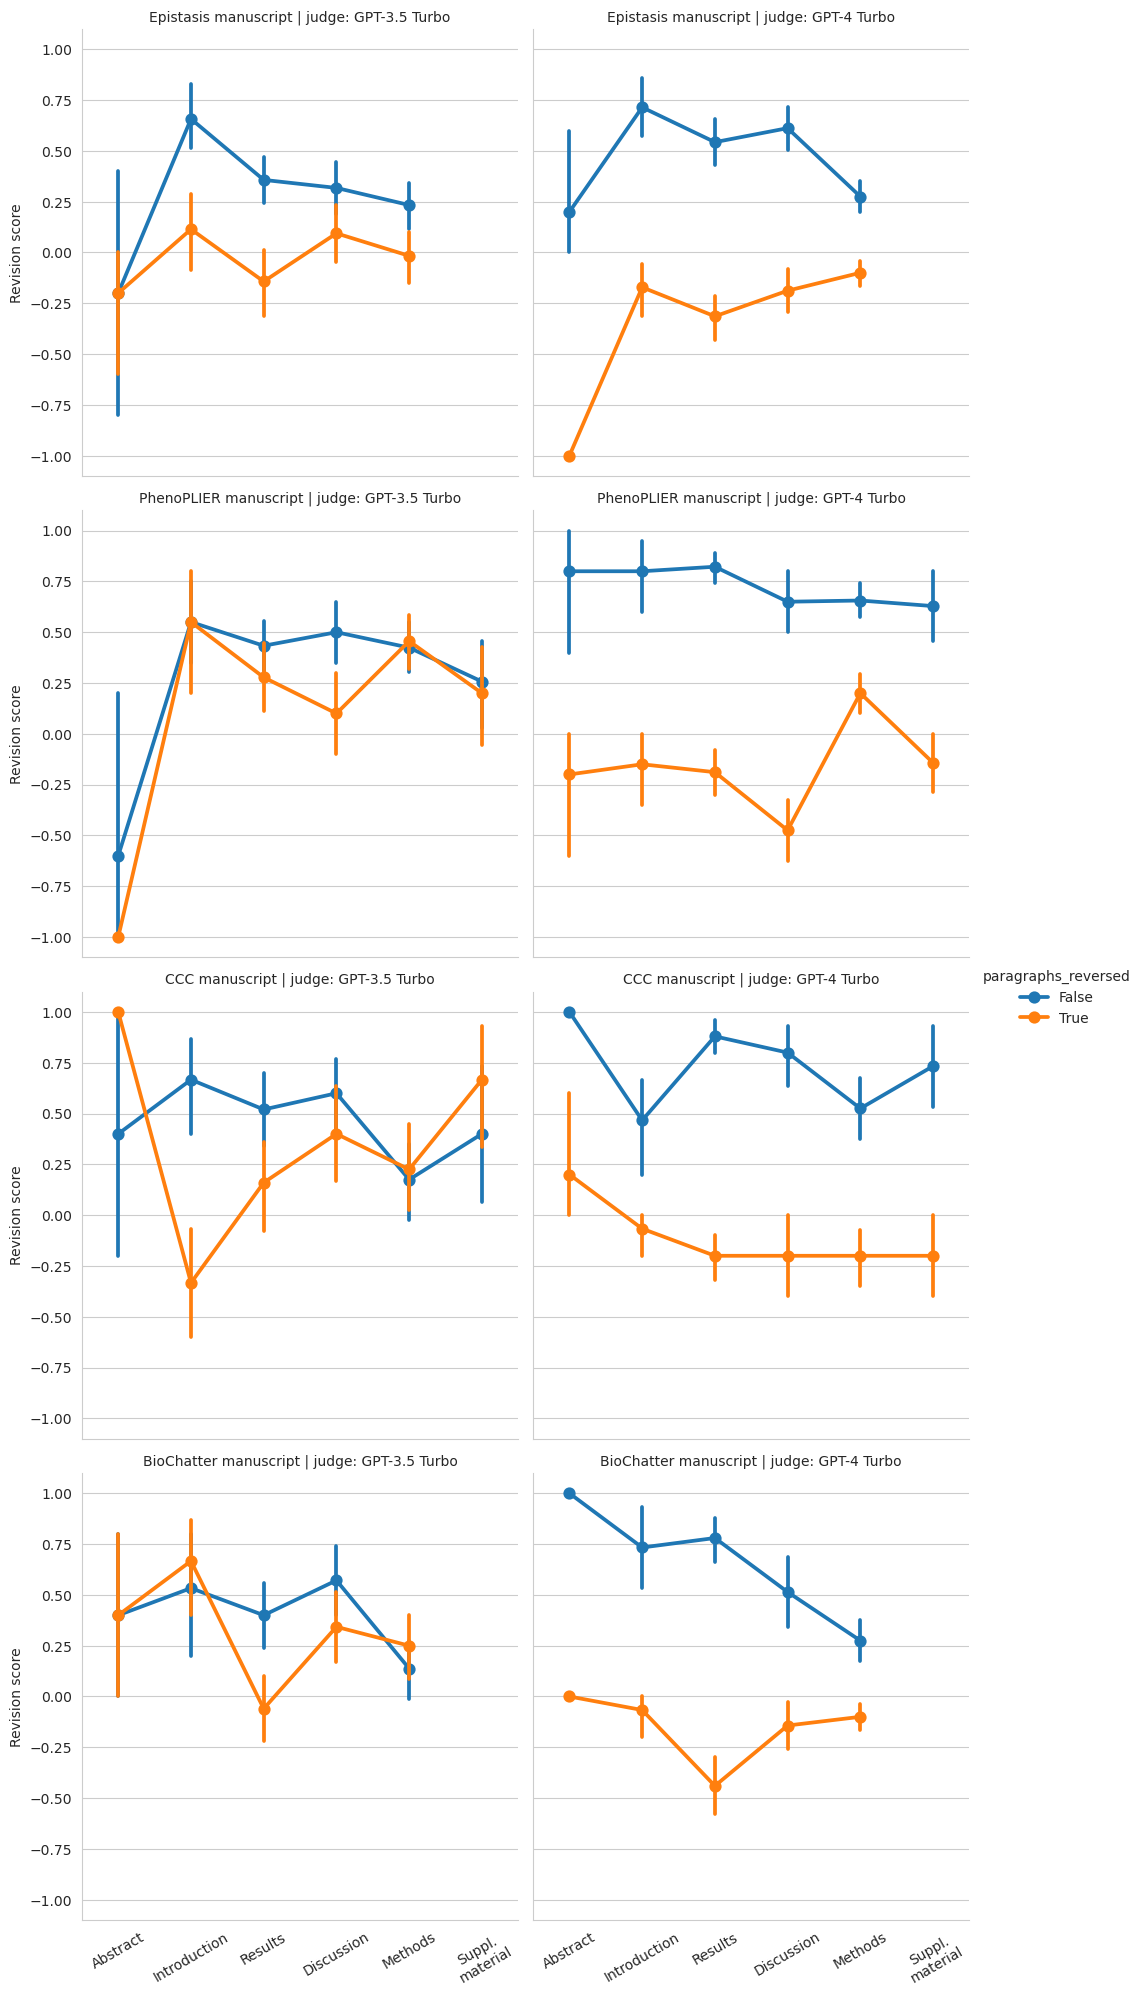

In [17]:
with sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=df,
        x="paragraph_section",
        y="winner_score",
        row="manuscript_code",
        col="llm_judge",
        kind="point",
        hue="paragraphs_reversed",
    )
    g.set_axis_labels("", "Revision score")
    g.set_titles("{row_name} manuscript | judge: {col_name}")
    g.tick_params(axis="x", rotation=30)

## Simple plot with all manuscript together

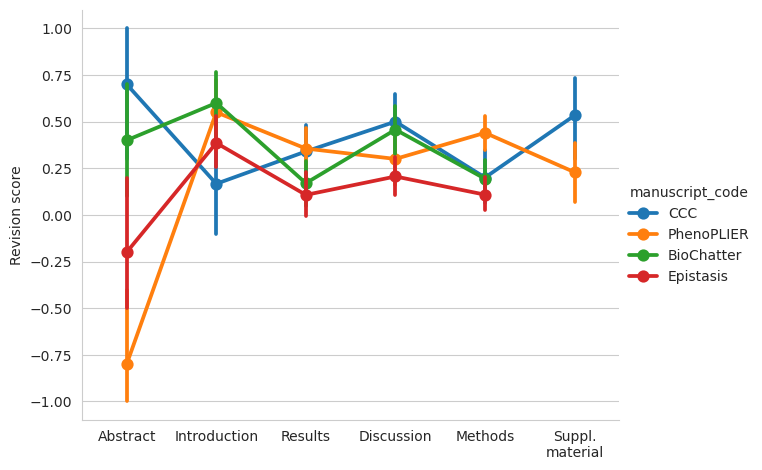

In [19]:
with sns.axes_style("whitegrid"):
    g = sns.catplot(
        height=5,
        aspect=1.3,
        data=df[df["llm_judge"] == "GPT-3.5 Turbo"],
        x="paragraph_section",
        y="winner_score",
        hue="manuscript_code",
        hue_order=["CCC", "PhenoPLIER", "BioChatter", "Epistasis"],
        # col_wrap=2,
        kind="point",
    )
    g.set_axis_labels("", "Revision score")
    g.set_titles("{col_name} manuscript")

## Plot with one panel per manuscript

'Saving figure to /home/miltondp/projects/others/manubot/manubot-gpt-manuscript/content/images'

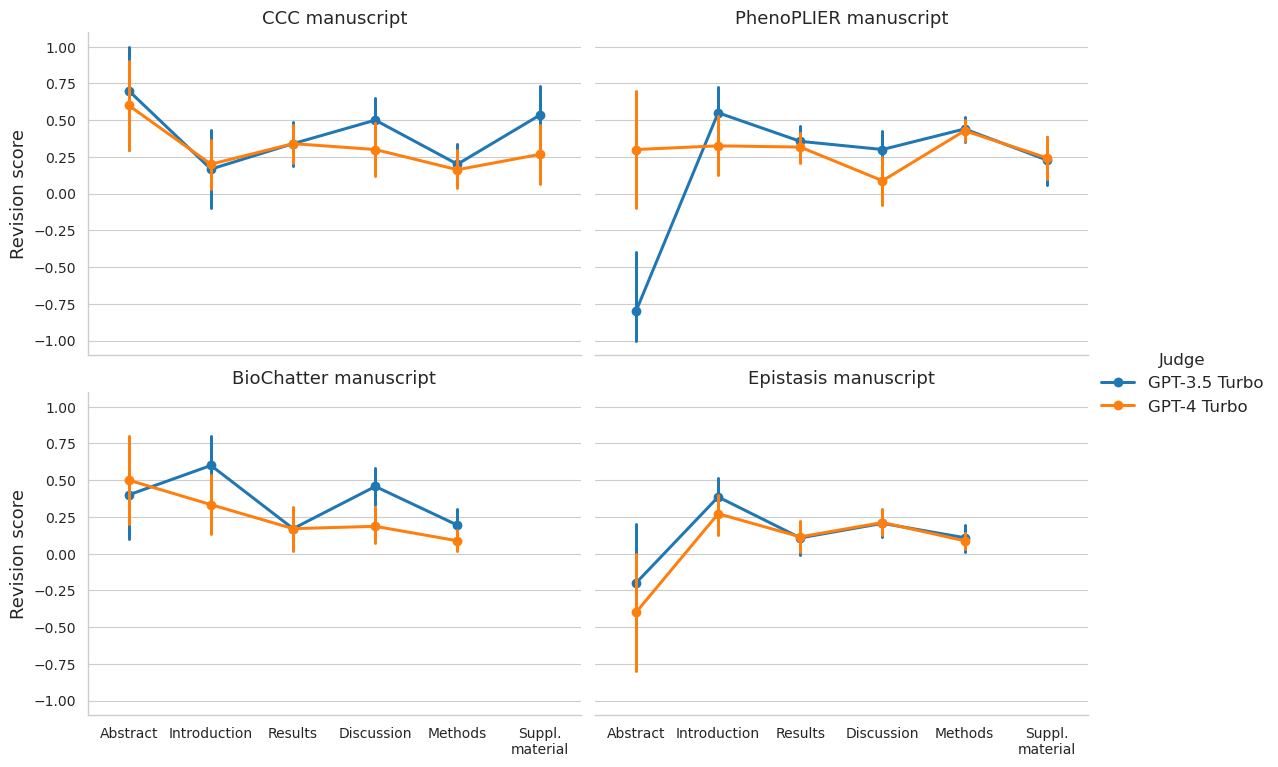

In [20]:
with sns.plotting_context(
    "paper",
    rc={
        "axes.labelsize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.title_fontsize": 12,
        "legend.fontsize": 12,
    },
), sns.axes_style("whitegrid"):
    g = sns.catplot(
        height=4,
        aspect=1.4,
        data=df[df["llm_judge"].isin(("GPT-3.5 Turbo", "GPT-4 Turbo"))],
        x="paragraph_section",
        y="winner_score",
        col="manuscript_code",
        col_order=["CCC", "PhenoPLIER", "BioChatter", "Epistasis"],
        col_wrap=2,
        kind="point",
        hue="llm_judge",
    )
    g.set_axis_labels("", "Revision score")
    g.set_titles("{col_name} manuscript")
    g._legend.set_title("Judge")
    for ax_idx, ax in enumerate(g.axes):
        if ax_idx in (1, 3):
            sns.despine(ax=ax, left=True)
            ax.yaxis.set_tick_params(left=False)

    if MANUSCRIPT_OUTPUT_DIR is not None:
        display(f"Saving figure to {MANUSCRIPT_OUTPUT_DIR}")
        g.savefig(MANUSCRIPT_OUTPUT_DIR / "llm_judge.svg")